In [1]:
import copy
import json
from typing import List

from CONST import SEED, POPULATION_SIZE, GENERATIONS, HISTORY_PATH
from neural_networks import FNN, CNN, CRNN
from utils import set_seed, plot_confusion_matrix, make_predictions, calculate_metrics, save_metrics
from algorithms import mu_lambda_es_evolve, de_best_1_bin_evolve, load_population, save_population

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, LSTM, Conv2D, MaxPooling2D, Reshape
from sklearn.model_selection import train_test_split


2024-01-29 19:14:22.530665: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 19:14:22.742265: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 19:14:22.744218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 19:14:24.367116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
set_seed(SEED)

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_images, val_images, train_labels, val_labels = train_test_split(test_images, test_labels, test_size=2000, random_state=SEED)

Epoch 1/5
125/125 [==============================] - 1s 2ms/step - loss: 1.8969 - accuracy: 0.4837
Epoch 2/5
125/125 [==============================] - 0s 2ms/step - loss: 1.1846 - accuracy: 0.7641
Epoch 3/5
125/125 [==============================] - 0s 2ms/step - loss: 0.8388 - accuracy: 0.8231
Epoch 4/5
125/125 [==============================] - 0s 2ms/step - loss: 0.6720 - accuracy: 0.8514
Epoch 5/5
125/125 [==============================] - 0s 2ms/step - loss: 0.5779 - accuracy: 0.8662
{'loss': [1.8968631029129028, 1.1845786571502686, 0.8388422131538391, 0.6719931364059448, 0.5778664350509644], 'accuracy': [0.48374998569488525, 0.7641249895095825, 0.8231250047683716, 0.8513749837875366, 0.8662499785423279]}
313/313 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: models/FNN_SGD/assets


INFO:tensorflow:Assets written to: models/FNN_SGD/assets


313/313 [==============================] - 1s 2ms/step
INFO:tensorflow:Assets written to: models/FNN_ES/assets


INFO:tensorflow:Assets written to: models/FNN_ES/assets


313/313 [==============================] - 1s 2ms/step


/home/kieru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: models/FNN_DE/assets


INFO:tensorflow:Assets written to: models/FNN_DE/assets


Epoch 1/5
125/125 [==============================] - 2s 15ms/step - loss: 2.1985 - accuracy: 0.3767
Epoch 2/5
125/125 [==============================] - 2s 15ms/step - loss: 1.3905 - accuracy: 0.7131
Epoch 3/5
125/125 [==============================] - 2s 15ms/step - loss: 0.5784 - accuracy: 0.8409
Epoch 4/5
125/125 [==============================] - 2s 15ms/step - loss: 0.4006 - accuracy: 0.8852
Epoch 5/5
125/125 [==============================] - 2s 15ms/step - loss: 0.3364 - accuracy: 0.8997
{'loss': [2.1984896659851074, 1.3905192613601685, 0.5784167647361755, 0.4005606472492218, 0.3364027738571167], 'accuracy': [0.37674999237060547, 0.7131249904632568, 0.8408750295639038, 0.8852499723434448, 0.8997499942779541]}
313/313 [==============================] - 1s 4ms/step
INFO:tensorflow:Assets written to: models/CNN_SGD/assets


INFO:tensorflow:Assets written to: models/CNN_SGD/assets


313/313 [==============================] - 1s 3ms/step


/home/kieru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: models/CNN_ES/assets


INFO:tensorflow:Assets written to: models/CNN_ES/assets


313/313 [==============================] - 1s 4ms/step


/home/kieru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: models/CNN_DE/assets


INFO:tensorflow:Assets written to: models/CNN_DE/assets


Epoch 1/5
125/125 [==============================] - 4s 23ms/step - loss: 2.2947 - accuracy: 0.1869
Epoch 2/5
125/125 [==============================] - 3s 22ms/step - loss: 2.2784 - accuracy: 0.2191
Epoch 3/5
125/125 [==============================] - 3s 25ms/step - loss: 2.2567 - accuracy: 0.2720
Epoch 4/5
125/125 [==============================] - 3s 25ms/step - loss: 2.2193 - accuracy: 0.2890
Epoch 5/5
125/125 [==============================] - 3s 26ms/step - loss: 2.1332 - accuracy: 0.3022
{'loss': [2.2947113513946533, 2.278397798538208, 2.256730556488037, 2.2193195819854736, 2.133186101913452], 'accuracy': [0.18687500059604645, 0.21912500262260437, 0.2720000147819519, 0.289000004529953, 0.3022499978542328]}
313/313 [==============================] - 2s 7ms/step


/home/kieru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: models/CRNN_SGD/assets


INFO:tensorflow:Assets written to: models/CRNN_SGD/assets


313/313 [==============================] - 2s 7ms/step


/home/kieru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: models/CRNN_ES/assets


INFO:tensorflow:Assets written to: models/CRNN_ES/assets


313/313 [==============================] - 2s 6ms/step


/home/kieru/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: models/CRNN_DE/assets


INFO:tensorflow:Assets written to: models/CRNN_DE/assets


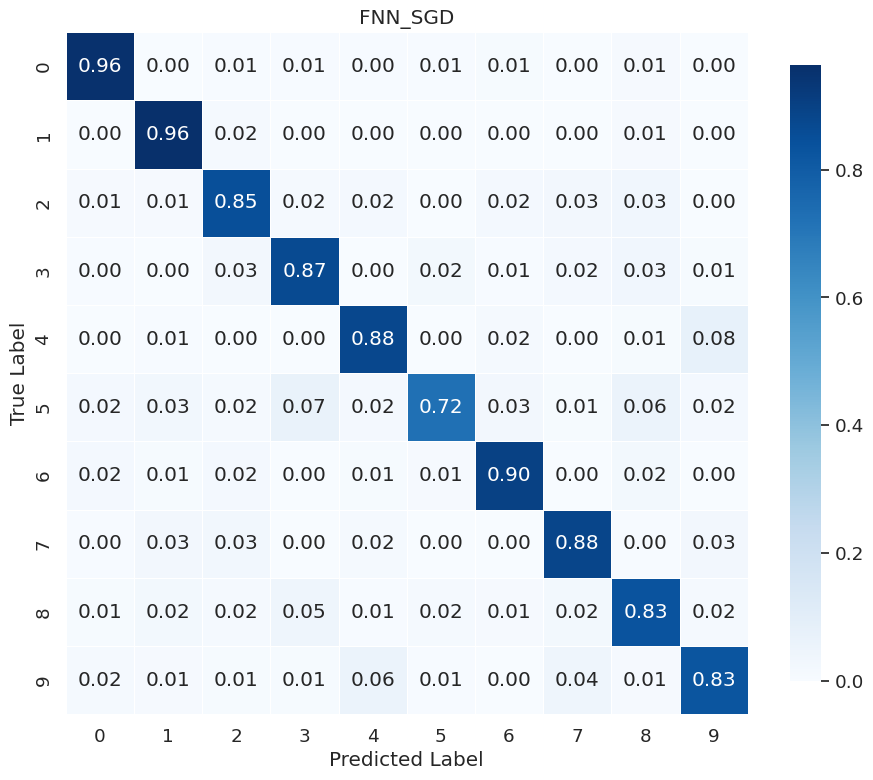

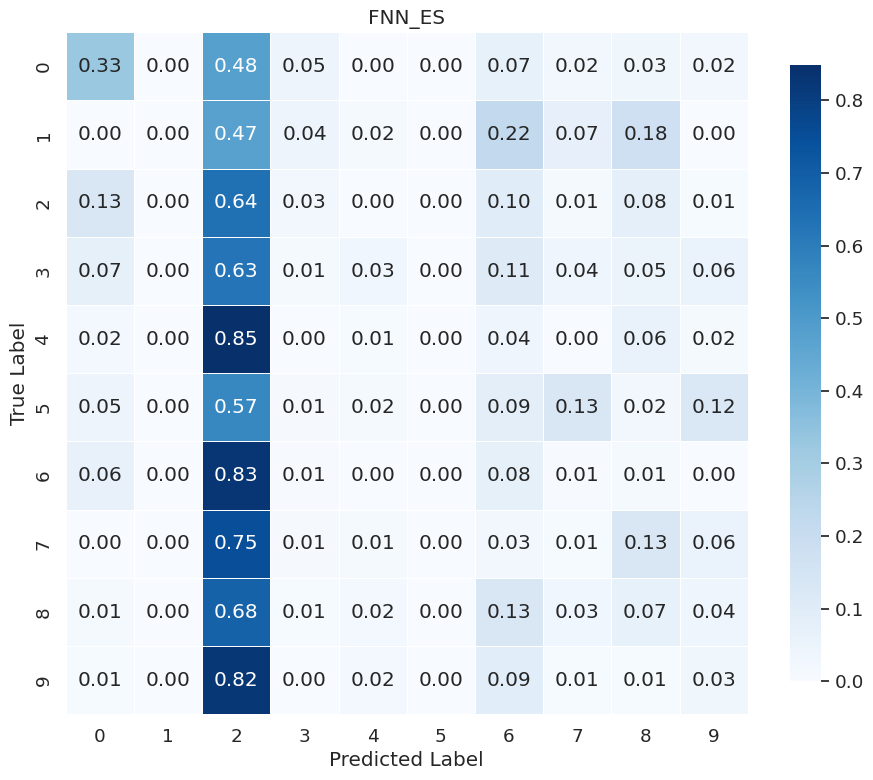

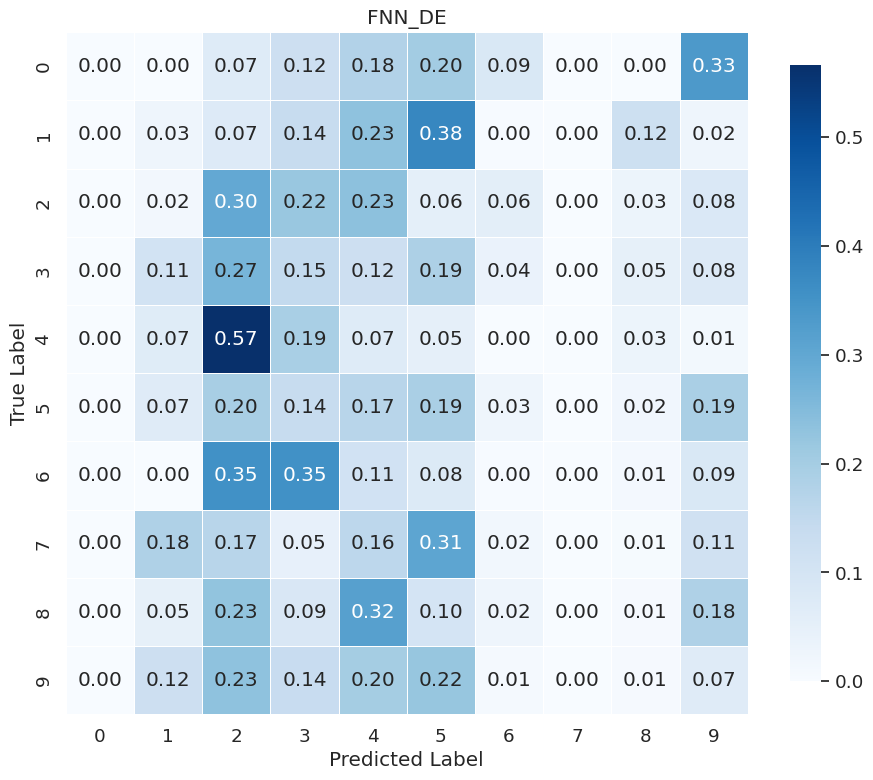

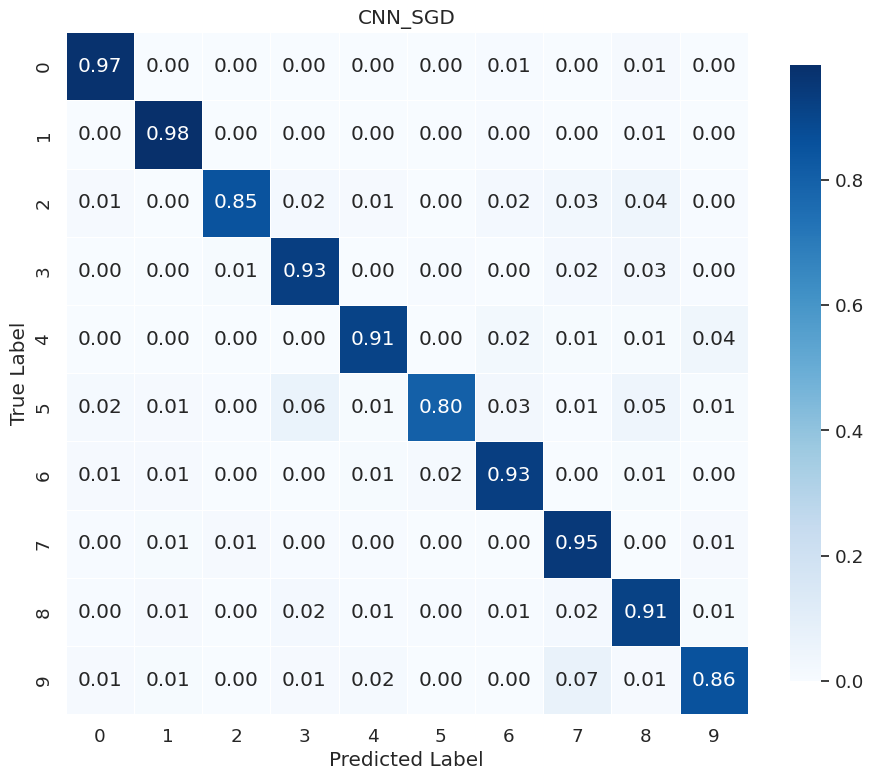

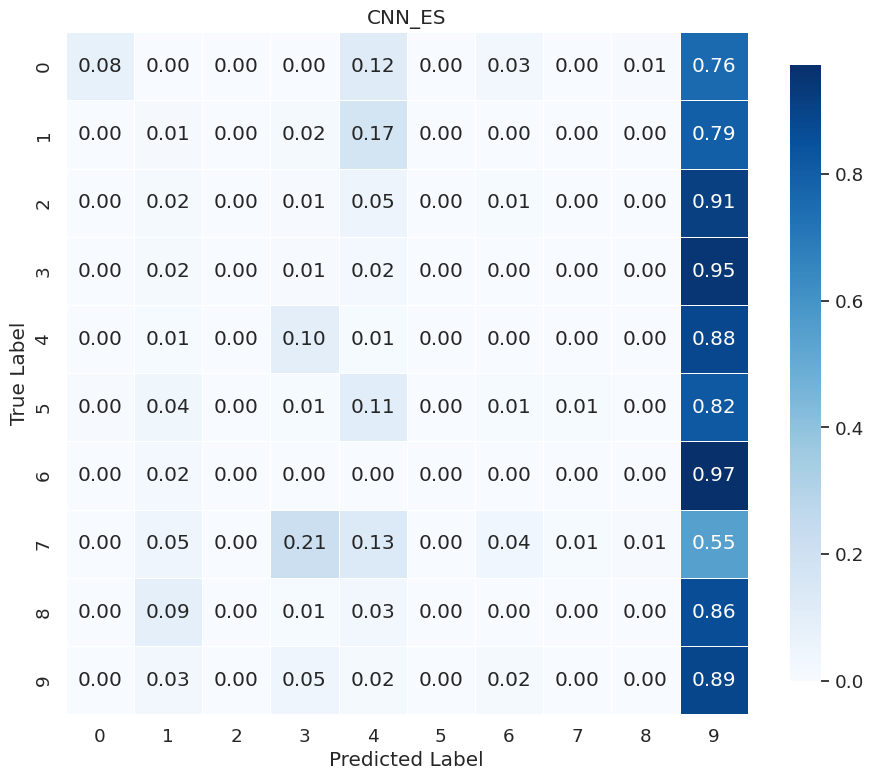

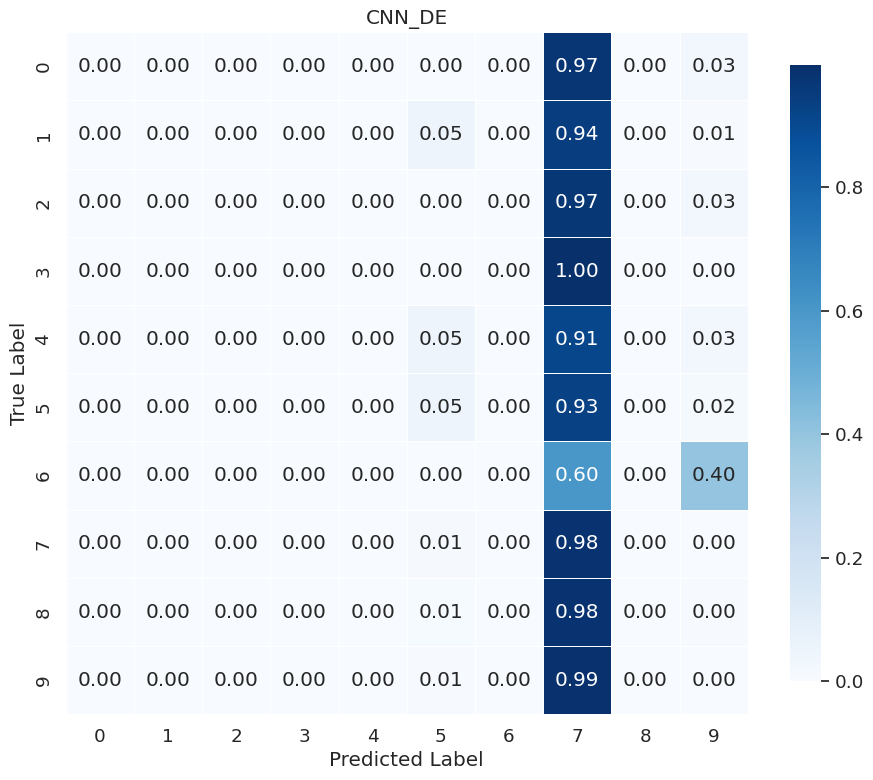

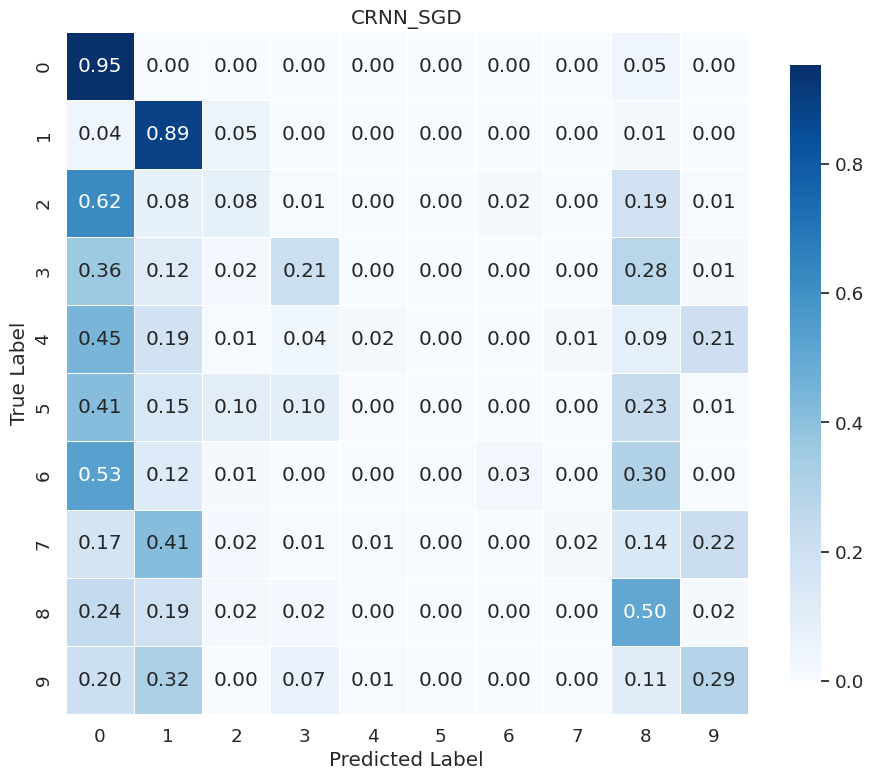

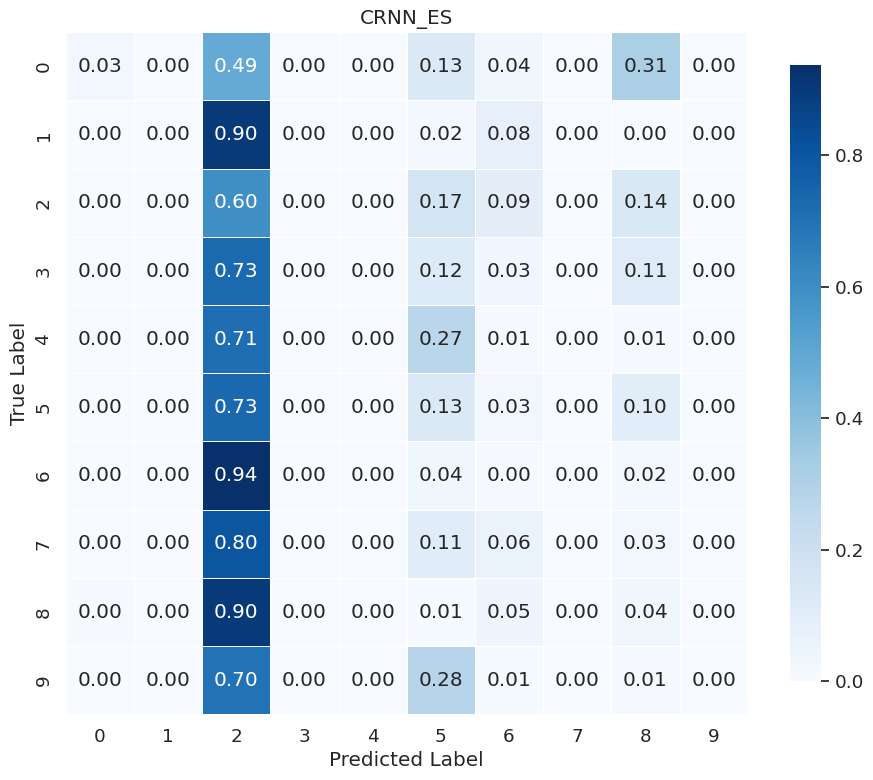

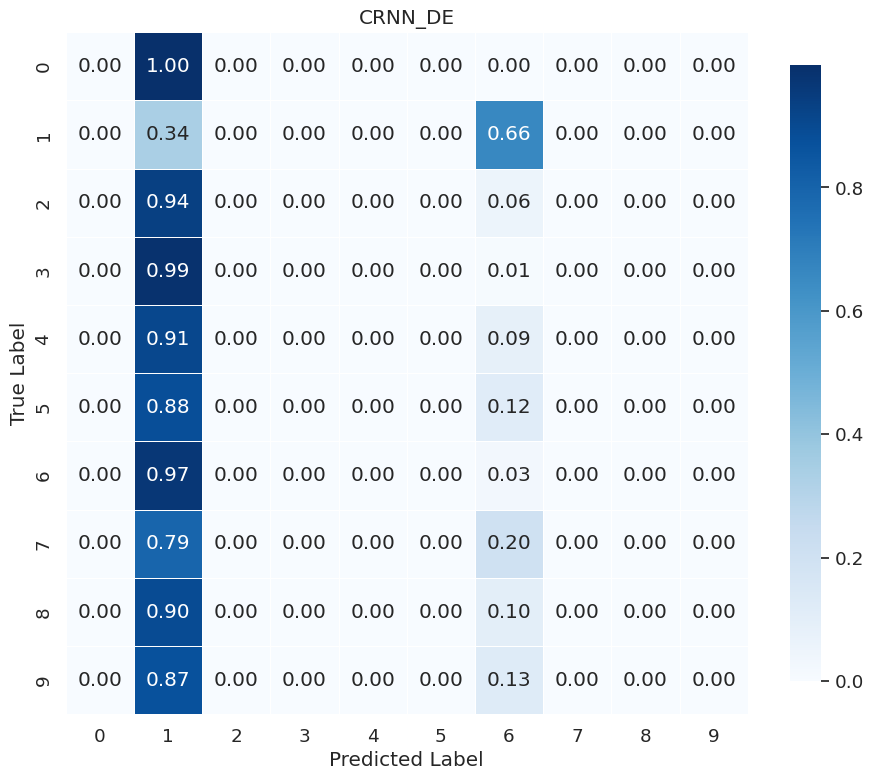

In [5]:
class_names = [str(i) for i in range(10)]

models: List[Model] = [
    FNN('SGD'), FNN('ES'), FNN('DE'),
    CNN('SGD'), CNN('ES'), CNN('DE'),
    CRNN('SGD'), CRNN('ES'), CRNN('DE')
]

for model in models:
    if model.info == 'SGD':
        model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        history_obj = model.fit(train_images, train_labels, epochs=5, batch_size=64, shuffle=True)
        history = history_obj.history['accuracy']

        with open(f'{HISTORY_PATH}sgd/{str(model)}.json', 'w') as f:
            json.dump(history, f)

    elif model.info == 'ES':
        model.build((1, 28, 28))

        best_individual, pop, history = de_best_1_bin_evolve(population_size=POPULATION_SIZE, 
                                                             generations=GENERATIONS, 
                                                             model=model, 
                                                             F=1, 
                                                             CR=0.2, 
                                                             test_images=val_images,
                                                             test_labels=val_labels, 
                                                             variant='cross', 
                                                             start_pop=None)
        
        with open(f'{HISTORY_PATH}de/{str(model)}.json', 'w') as f:
            json.dump(history, f)

        model.set_weights(best_individual)

    elif model.info == 'DE':
        model.build((1, 28, 28))

        best_individual2, pop, history = mu_lambda_es_evolve(mu=5, 
                                                             lambda_=5, 
                                                             sigma=0.1, 
                                                             generations=10, 
                                                             test_images=val_images,
                                                             test_labels=val_labels, 
                                                             model=model,  
                                                             variant='cross', 
                                                             start_pop=None)

        with open(f'{HISTORY_PATH}es/{str(model)}.json', 'w') as file:
            json.dump(history, file)

        model.set_weights(best_individual)


    predicted_labels = make_predictions(model, test_images)

    accuracy, precision, recall, conf_matrix = calculate_metrics(predicted_labels, np.argmax(test_labels, axis=1))
    save_metrics(str(model), accuracy=accuracy, precision=precision, recall=recall)
    # print(f'{str(model)} Evaluation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    # print('Confusion Matrix:')
    # print(conf_matrix)
    
    plot_confusion_matrix(conf_matrix, class_names, title=f'{str(model)}', save=True)

    model.save(f'models/{str(model)}', save_format='tf')  